## Kaggle Kernel Study: Titanic dataset
#### references (kernel name)
- Introduction to Ensembling/Stacking in Python  
- Titanic best working Classifier  

> Upvote 수가 많은 유명 kernel들을 위주로 필사하고 번역하면서 공부함. 선정 kernel의 내용을 그대로 필사하기보단 스스로의 생각과 의견을 반영하도록 하고, 설명이 부족한 부분이나 모르는 부분은 직접 작성하면서 공부하기 때문에 실제 reference kernel 내용하고 다를 수 있음

### Introduction

- 앙상블 학습을 하는 기초적인 방법을 제시하는 노트북  

- 특히 앙상블 학습 중 Stacking이란 방법을 설명  

- Stacking은 첫번째 단계에서 base model로 예측한 후 두번째 단계에서 첫번째 때 구했던 예측값을 토대로 다른 model을 적용하여 실제 output을 예측하는 것으로 간단히 요약  

- Titanic 데이터는 앙상블 학습법 뿐만 아니라 데이터 분석을 처음 시작하는 사람들에게 적합한 데이터. 또한 많은 사람들이 review했던 데이터지만 Stacking에 대한 내용이 드문 경우를 고려하여 작성됨  

In [1]:
import pandas as pd # 데이터 편집 및 처리
import numpy as np # 행렬 대수 수치 계산
import re # 정규표현식 모듈
import sklearn # machine learning package
import xgboost as xgb # tree 기반 boosting model (최종 meta model)
import seaborn as sns # 시각화 툴
import matplotlib.pyplot as plt # 시각화 툴
# matplotlib 시각화를 현재 창에서 바로 보여주도록 함
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # 가끔 버전 업과 같은 이유로 경고메세지 출력되는 것 무시

# Stacking을 위한 base model로 5가지를 사용할 것임
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier)
from sklearn.svm import SVC # 서포트 벡터 머신 분류기
from sklearn.model_selection import KFold # KFold 교차검증

### Feature Exploration, Enginieering and Cleaning
- 대부분의 Kaggle Kernel (Notebook)이 구성하는 일반적인 방식으로 시작  

- 데이터 탐색, feature engineering 기회가 있는지 알아보기, 범주형 데이터 인코딩등의 작업이 필요

In [2]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 예측결과에 index별로 접근할 수 있도록 passenger ID값 저장
PassengerId = test['PassengerId']

train.head(3) # 3번째 행 까지만 출력

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


여기서, 우리는 데이터가 갖는 범주형 변수(categorical variables)들을 잘 활용하여 정보를 얻어낼 수 있도록 해야함

#### Feature Engineering
이제, feature engineering을 진행하거나 이에 필요한 아이디어를 얻기 위해 범주형 변수들을 분석하거나 수치값을 가지지만 범주형으로 만들수 있는 변수에 대해서 레이블(또는 target 변수)에 영향이 있는 변수들을 확인해야함

In [3]:
print(train.info()) # train dataset의 전체 관측값 개수는 891
print(test.info()) # test dataset의 전체 관측값 개수는 418

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

결측값을 갖는 컬럼은 Age, Cabin, Embarked, Fare

#### 1. Pclass
Pclass는 결측값이 없고 이미 수치형 값을 갖는 categorical variable. target인 'Survived'에 영향이 있는지 조사

In [4]:
# train 데이터의 'Pclass', 'Survived' 컬럼을 조회
# 단, 'Pclass' 기준으로 묶어서 조회하고 index를 따로 사용하지 않는 조건
# 조회 시 평균값으로 조회
print(train[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Pclass(선실등급)에 따라 생존률이 분명한 차이가 있기 때문에 영향이 있다고 볼 수 있음

#### 2. Sex
마찬가지로, 결측값이 없는 범주형 변수로, Pclass와 동일한 방법으로 조사

In [5]:
print(train[['Sex','Survived']].groupby(['Sex'], as_index = False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


성별에 따라 매우 큰 차이가 발생함을 확인할 수 있음 (추측: 여성과 아이들 먼저 살리고자 하는 통념)

#### 3. SibSp and Parch
형제자매/배우자 수와 자녀/부모의 수를 가지고 새로운 feature인 'Family Size'를 만들어 분석에 이용

In [6]:
full_data = [train,test] # 2개 값을 가진 list에 넣기 (train,test 모두 한꺼번에 편집하길 원함)
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # +1은 본인
    # full_data 내의 2개의 dataframe 모두 'FamilySize' column 생성

print(train[['FamilySize','Survived']].groupby(['FamilySize'],as_index = False).mean())


   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


가족 규모에 따라서 생존률의 차이가 분명히 존재하고, 부양 가족이 많을수록 생존률이 낮은 경향이 있음. 이 결과도 예측에 많은 도움이 될 것으로 예상하지만, 혼자 탑승했는지 아닌지 여부를 좀 더 조사해봄 (혼자인 경우 살아남을 확률이 더 높을 수도 있기 때문에)

In [7]:
for dataset in full_data:
    dataset['IsAlone'] = 0 # 혼자 탑승 여부를 기록하는 IsAlone 컬럼 생성
    # FamilySize가 1(혼자)인 IsAlone의 값을 1(혼자 탑승)로 바꿈
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

print(train[['IsAlone','Survived']].groupby(['IsAlone'],as_index = False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


확실히 혼자 탑승한 사람의 경우 생존률이 분명하게 떨어지는 경향이 있음을 확인

#### 4. Embarked
Embarked는 결측값이 존재하기 때문에 결측값을 대체할 수 있어야함

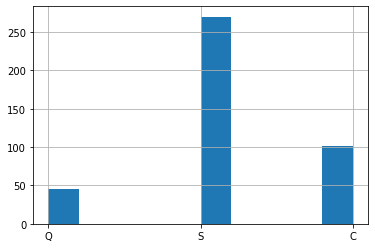

In [8]:
test.Embarked.hist()
plt.show()

'S'가 월등히 많이 포함되어 있으므로, 결측값을 'S'로 대체할 경우 실제 데이터의 분포에 영향을 많이 미치지 않기 때문에 대체값은 'S'로 정함. 이제 다음과 같이 column impact를 조사

In [9]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print(train[['Embarked','Survived']].groupby(['Embarked'], as_index = False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


위 결과로 Embarked 구분에서 어느정도 차이가 있음을 간략히 확인하였음

#### 5. Fare
Fare도 Embarked와 마찬가지로 결측값이 존재함. 다음과 같이 Fare의 분포를 확인해봄

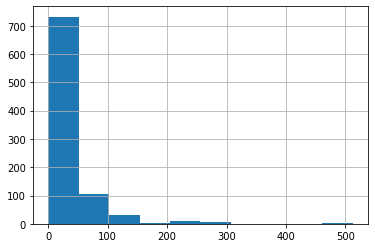

In [10]:
train.Fare.hist()
plt.show()

전반적으로 0~50 사이에 많이 분포되어 있으며, 100 이상의 값은 상당히 적은 편임. Fare(요금)의 결측값을 대체할시 평균을 고려할 수 있지만, 평균은 큰 값에 영향을 많이 받기 때문에 최종적으로는 실제 분포에 영향을 미칠 수 있게됨. 따라서 중앙값을 사용하는 것이 더 합리적임 (사실 null값이 매우 적은 경우이기 때문에 그냥 drop 해주어도 무방하다고 생각됨)

또한, Fare가 Survived에 미치는 영향을 살피기 위해서는 범주화시킬 필요가 있음. 약 4개 범주안에 들어가도록 새로운 컬럼을 생성해야함

In [11]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median()) # 중앙값으로 결측값 대체

# 실제 데이터는 discrete 하지만, 변수 속성 자체는 continuous 함
# 이산화하여 (동일 길이로 나누어서) 범주를 만들기 위해 pandas.qcut() 함수 사용
train['CategoricalFare'] = pd.qcut(train['Fare'],4) # Fare 컬럼을 4분할
print(train[['CategoricalFare','Survived']].groupby(['CategoricalFare'],as_index = False).mean())


   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


요금이 높을수록 생존률이 높아짐

#### 6. Age
Age 또한 결측값이 존재하고, 연속형(continuous) 속성을 갖지만 범주화할 수 있는 변수이므로 범주화를 진행하도록 함. 결측값 대체는 다양한 방법이 있으나 참조하는 커널에서는 단순히 평균값으로 대체하지 않고 평균을 기준으로 표준편차 범위 안에서의 난수로 대체함

굳이 난수를 생성해서 결측값을 만드는 이유는 다음과 같이 추정됨

- 특정 하나의 값으로만 대체할 경우 그 값에 대한 trend가 생겨 왜곡될 가능성
- 연령층이 분포에 영향을 주지 않는 범위에서 고르게 분포될 수 있도록 하기 위함

In [12]:
for dataset in full_data:
    age_mean = dataset['Age'].mean() # 평균
    age_std = dataset['Age'].std() # 표준편차
    age_null_count = dataset['Age'].isnull().sum() # 결측값 개수
    
    # 지정된 구간의 uniform distribution에서 null 개수만큼 정수 난수 뽑기
    age_null_random_list = np.random.randint(age_mean - age_std,age_mean + age_std, size = age_null_count)
    
    # 아래의 np.isnan(dataset['Age']) 은 사실 dataset['Age'].isnull()로 해주어도 상관없음
    # 두 경우 모두 Series Type, dtype은 bool로 같음
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list # 결측값 자리에 난수 넣어줌
    dataset['Age'] = dataset['Age'].astype(int) # int로 형변환 (연령층이므로 소수점은 굳이 필요 X)
    
# 앞서 범주를 나눈 함수는 qcut()이고 이번에는 cut()을 사용함
# qcut: 특정 분위수를 계산하여 이를 기반으로 이산화 수행
# cut: 사용자가 이산화할 수치를 직접 입력
# qcut(x,q): 이산화할 배열 x, q 는 분위수의 숫자. q = 5면 5분위수
# cut(x,bins): 이산화할 배열 x, bins = int 면 동일하게 분할할 숫자, array면 비동일 분할
train['CategoricalAge'] = pd.cut(train['Age'],5)

print(train[['CategoricalAge','Survived']].groupby(['CategoricalAge'], as_index = False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.500000
1   (16.0, 32.0]  0.363839
2   (32.0, 48.0]  0.365462
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


연령층에 대한 차이가 있으나, 큰 impact가 있다고 보긴 어려움. 아이들이 전반적으로 생존률이 높고 노인층의 생존률이 극히 낮은 것은 어느정도 타당한 결과. (보통 아이와 여성, 노인들을 먼저 구조하고 난 뒤 나머지가 탈출)

#### 7. Name
이름은 이름을 수식하는 title을 조사

In [13]:
train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [14]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # 정규표현식으로 'XXXX.' 꼴 찾기
    if title_search: # title이 비어있지 않으면
        return title_search.group(1) # 값 반환 (개당 반환이라 group은 신경쓰지 않아도 됨)
    return ''

for dataset in full_data:
    # apply() 함수를 통해 사용자 정의 함수를 데이터프레임에 적용할 수 있음
    dataset['Title'] = dataset['Name'].apply(get_title)
    
print(pd.crosstab(train['Title'],train['Sex'])) #행을 title, 열을 sex로 보여주는 cross table 출력

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


만들어진 title 목록 중 많은 count를 차지하는 title은 몇개 없으므로 이를 정리

In [15]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col',\
                                                'Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],\
                                               'Rare')
    # 묶일 수 있는 것들은 합쳐줌
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
print(train[['Title','Survived']].groupby(['Title'],as_index = False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


이름에서도 여성을 수식하는 title이 생존률이 높음을 확인할 수 있음

#### Data Cleaning

categorical value를 갖는 컬럼들을 numerical value로 바꾸어주는 작업을 진행. 인코딩 관련 sklearn 모듈을 사용하지 않고 직접 정리

In [16]:
for dataset in full_data:
    
    # Feature encoding
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int) # float 자동변환 방지
    
    title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) # title이 없는 이름의 경우
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    '''
       CategoricalFare  Survived
    0   (-0.001, 7.91]  0.197309
    1   (7.91, 14.454]  0.303571
    2   (14.454, 31.0]  0.454955
    3  (31.0, 512.329]  0.581081
    '''
    dataset.loc[dataset['Fare'] <= 7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    '''
      CategoricalAge  Survived
    0  (-0.08, 16.0]  0.527273
    1   (16.0, 32.0]  0.359551
    2   (32.0, 48.0]  0.363281
    3   (48.0, 64.0]  0.434783
    4   (64.0, 80.0]  0.090909
    '''
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [17]:
# Feature selection
drop_elements = ['PassengerId','Name','Ticket','Cabin']
train = train.drop(drop_elements,axis = 1)
# 앞서 categorical age,fare를 가지고 인코딩해주었기 때문에 필요없으므로 drop
train = train.drop(['CategoricalAge','CategoricalFare'],axis = 1)

test = test.drop(drop_elements,axis = 1) # test용이므로 건드릴 필요 X. drop할 feature만 제거

print(train.head(10))

   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  FamilySize  \
0         0       3    1    1      1      0     0         0           2   
1         1       1    0    2      1      0     3         1           2   
2         1       3    0    1      0      0     1         0           1   
3         1       1    0    2      1      0     3         0           2   
4         0       3    1    2      0      0     1         0           1   
5         0       3    1    0      0      0     1         2           1   
6         0       1    1    3      0      0     3         0           1   
7         0       3    1    0      3      1     2         0           5   
8         1       3    0    1      0      2     1         0           3   
9         1       2    0    0      1      0     2         1           2   

   IsAlone  Title  
0        0      1  
1        0      3  
2        1      2  
3        0      3  
4        1      1  
5        1      1  
6        1      1  
7        0    

위 결과에서 볼 수 있듯, 모든 변수가 numeric하게 정돈됨으로써 모델을 학습시키기에 알맞은 형태가 됨

### Visualisations

#### Pearson Correlation Heatmap

상관관계를 시각화하는 다양한 방법 중, Heatmap을 통해 이를 확인할 수 있음. Heatmap은 행렬로 표현된 자료의 행렬 원소값에 따라 색을 부여해서 행렬 크기와 같은 격자판에 나타내는 시각화 기법으로, 여기에선 상관계수 행렬을 구한 뒤 Heatmap으로 표현함

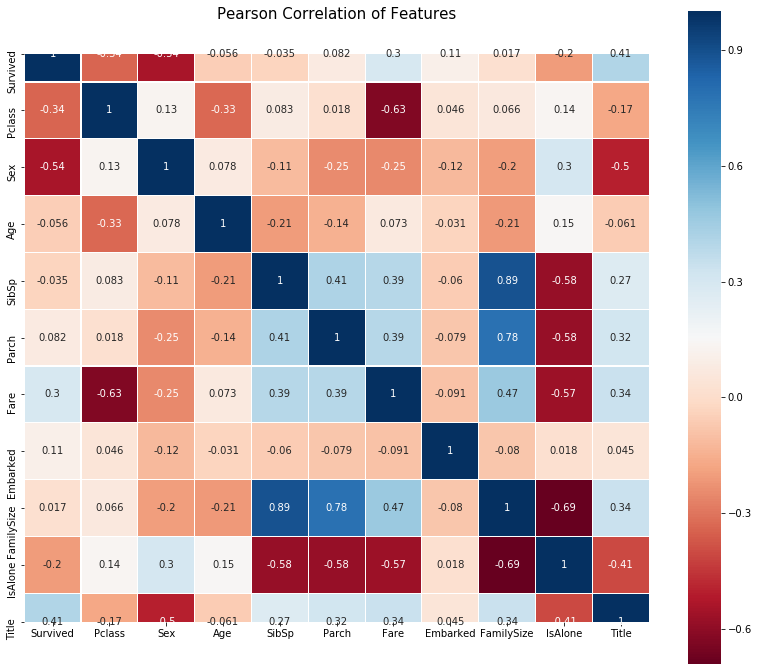

In [18]:
colormap = plt.cm.RdBu # 팔레트 지정
plt.figure(figsize = (14,12)) # 그래프 크기 지정
plt.title('Pearson Correlation of Features',y = 1.05, size = 15) # 제목 지정
# 선 두께 0.1, 최대값 1, square가 참이면 상삼각행렬부분까지 다 보여줌, annot이 참이면 셀에 값 표시 
sns.heatmap(train.astype(float).corr(),linewidths = 0.1,vmax = 1.0, square = True,\
            cmap = colormap, linecolor = 'white', annot = True)
plt.show()

#### Takeaway from the Plots
- Pearson 상관관계 플롯을 출력한 결과를 보면, 특정 변수를 제외하면 뚜렷한 상관성이 보이는 변수가 없다는 것을 확인  

- FamilySize와 관련된 변수인 IsAlone, Parch, SibSp의 경우는 상관성이 높은 편이므로 해당 컬럼과 중복되거나 불필요한 데이터가 많다는 의미  

- 즉, 상관성이 높은 경우는 학습 데이터셋에 불필요한 데이터가 있거나 중복되는 것이 있다는 의미이므로 해당되는 컬럼 중 나머지 변수들과 상관관계가 가장 적은 컬럼을 제외하고 제거하는것이 좋음

In [19]:
drop_elements = ['SibSp','Parch', 'FamilySize'] # IsAlone만 남기고 제거
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

print (train.head(3))

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2


#### Pairplots
데이터의 분포를 직접적으로 확인하기 위해서 pairplot을 사용. pairplot은 서로다른 두 변수에게는 산점도를, 자기 자신은 분포곡선(diag_kind = 'kde')을 그려줌

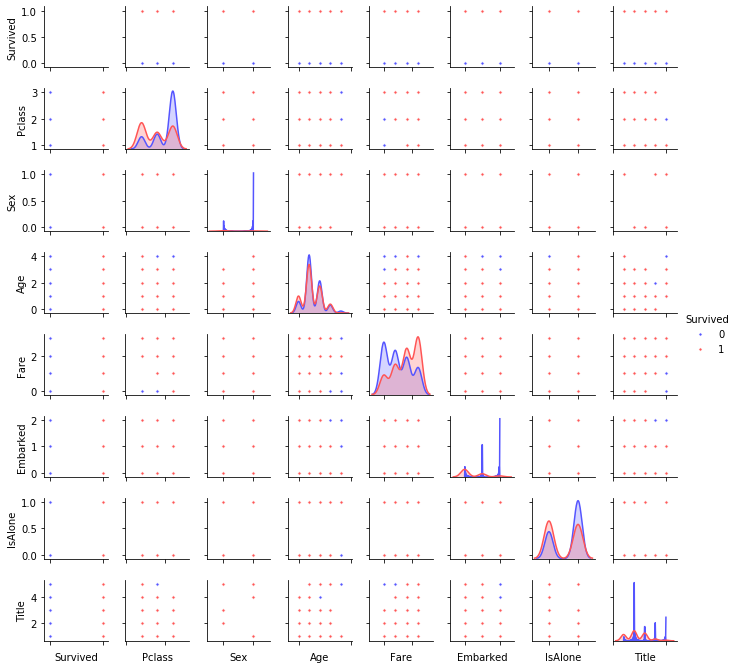

In [20]:
# {plot, diag, grid}_kws: dicts
# Dictionaries of keyword arguments.
# plot_kws are passed to the bivariate plotting function,
# diag_kws are passed to the univariate plotting function,
# and grid_kws are passed to the PairGrid constructor.
g = sns.pairplot(data = train, hue = 'Survived',palette = 'seismic',\
                 size = 1.2, diag_kind = 'kde',diag_kws = dict(shade = True),plot_kws = dict(s = 10))
g.set(xticklabels = [])
plt.show()

### Ensembling & Stacking models
Note) 앙상블 기법: 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking)  
- 배깅: 부트스트랩을 이용한 병렬, 복원추출 (동일모델 여러개)
- 부스팅: 순차적, 복원추출 & 가중치를 주는 방식 (동일모델 여러개)
- 스태킹: 개별 모델 여러개가 예측한 데이터를 다시 학습 데이터로 활용해서 학습

본격적으로 앙상블 학습 및 스태킹 모델을 만들기 위해서 Python의 Class를 이용하여 코드를 작성할 필요가 있음. 이는 코드 간소화 및 작업 효율화를 위함 

In [21]:
# 차후에 쓸 주요 파라미터들을 미리 정의
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # random seed 고정
NFOLDS = 5 # Kfold 교차검증 시 데이터 분할 수
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# 사이킷런 base model 구축을 위한 Class 만들기
class SklearnHelper(object):
    def __init__(self,clf,seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params) # **params: params를 dictionary로 저장
        # *args: 정해지지 않은 수의 일반 파라미터를 받음
        # **kwargs: 정해지지 않은 수의 키워드 파라미터를 받음 (딕셔너리)
        
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

#### Out-of-Fold (OOF) Predictions
Stacking은 1차적으로 basemodel들로부터 예측한 결과값을 Input으로 2단계 모델에서(Meta model) 최종 예측값을 구하게 되는데, 전체 데이터를 학습시키게 되면 이미 모델이 '확인했던' 데이터셋이므로 과적합이 발생하게 됨.  

OOF Prediction은 Cross Validation 기반의 Prediction을 지칭하며, Stacking에서는 아래의 이미지와 같은 방식의 예측을 하는 것을 말함.  

- base model인 Model 1 ~ Model 5 까지 KFold 교차검증을 통해 예측값을 구함  

- Model 1 ~ 5 까지의 예측값을 다시 합쳐서 새로운 학습 데이터셋을 만듬  

- 예측값들로 만들어진 새로운 학습 데이터를 meta model (본모델)에 학습시켜 최종적으로 예측

- 이러한 과정에서 meta model에 필요한 새로운 학습데이터를 구축하는 방식을 OOF 라고함

![Stacking_datasets](Stacking_dataset.png)

In [22]:
# 개별 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하는 함수
def get_oof(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,)) # predict할 컬럼은 1개('Survived')이므로 1줄짜리 배열
    oof_test = np.zeros((ntest,)) # predict할 컬럼은 1개('Survived')이므로 1줄짜리 배열
    oof_test_skf = np.empty((NFOLDS,ntest)) # NFOLDS X ntest 크기의 빈 배열 생성
    
    i = 0
    for train_index, test_index in kf.split(x_train): # KFold로 split된 데이터 index 호출
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr,y_tr) # KFold로 분할된 크기만큼 base model 학습
        
        oof_train[test_index] = clf.predict(x_te) # level 1 예측결과로 생성된 학습데이터
        # oof_train 은 최종 모델의 학습 데이터
        oof_test_skf[i,:] = clf.predict(x_test) # level 1 예측결과로 생성된 테스트 데이터
        i += 1
        
    oof_test[:] = oof_test_skf.mean(axis = 0) # 최종 모델의 테스트 데이터
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1) # 열벡터 형태로 뽑아냄

### Generating our Base First-Level Models
다음의 5가지의 base model을 선정함

   1. Random Forest classifier  
   2. Extra Trees classifier  
   3. AdaBoost classifier  
   4. Gradient Boosting classifier  
   5. Support Vector Machine

#### Parameters
파라미터 중 주요한 것들을 간략히 살펴보면 다음과 같다.  

- __n_jobs__ : 학습을 위해 필요한 core 수. 만약 -1로 설정하면 모든 core가 사용됨

- __n_estimators__ : 학습 모델에서 사용할 트리의 개수(Bagging, Boosting의) default = 10

- __max_depth__ : 트리의 최대 깊이 또는 노드를 얼마나 많이 확장시킬 것인지 결정. 너무 많은 값을 주면 트리가 과도하게 깊어지면서 과적합이 일어날 수 있음  

- __verbose__ : 학습을 진행하는 동안 학습과정과 관련한 모든 텍스트를 출력할지 말지 여부를 결정. 0이면 텍스트 출력을 하지 않고 3이면 매 반복마다 텍스트를 출력

In [23]:
# 파라미터 값 설정
# rf, et, gb 는 트리 기반이므로 파라미터를 공유
# 파라미터 값에 대한 상세한 정보나 표준 값들에 대한 것은 본 주제에서 어긋나므로 kernel 작성자의 값을 그대로 가져옴

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [24]:
# base model 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [25]:
# model에 학습 및 예측을 위해 데이터를 numpy 배열로 바꿈
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis = 1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

#### Output of the First level Predictions
OOF 함수를 이용해서 5가지 base model을 학습

In [26]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


#### Feature importances generated from the different classifiers
학습한 base model의 feature importance를 확인

In [27]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.20114353 0.24034775 0.05642972 0.11074569 0.0425756  0.03663963
 0.31211809]
[0.18980072 0.38935317 0.0481872  0.08760456 0.04178809 0.03579075
 0.20747552]
[0.022 0.326 0.03  0.04  0.026 0.012 0.544]
[0.17817389 0.04199799 0.06681657 0.1008517  0.04218884 0.01981585
 0.55015515]


In [28]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

#### Interactive feature importances via Plotly scatterplots
feature importance를 걸러내는 시각화 내용은 skip

### Second-Level Predictions from the First-level Output
#### First-level output as new features

base model로 예측한 결과값들을 학습데이터로 meta model 에 학습

In [29]:
# ravel() : 1차원 배열로 펴주는 함수 (flatten)
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second Level Training set
예측 결과값이라고 해도 이제는 feature 데이터셋이기 때문에 상관관계 분석을 실시

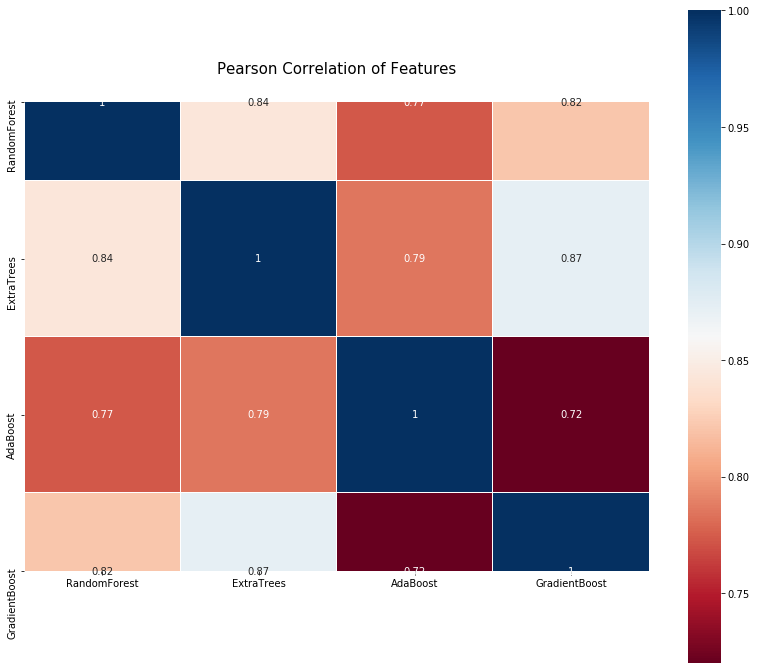

In [30]:
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features',y = 1.05, size = 15)
sns.heatmap(base_predictions_train.astype(float).corr(),linewidths = 0.1,vmax = 1.0,\
            square = True,cmap = colormap, linecolor = 'white', annot = True)
plt.show()

모델 결과 끼리도 상관성이 낮을수록 더 나은 score를 보장해줌을 많은 competition에서 보여주고 있음을 참고

In [31]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

우선 모든 feature를 사용하기로 하고 level 2 meta model을 위한 데이터를 만든다.

#### Second level learning model via XGBoost
Kaggle competition에서 자주 사용되고 있는 모델인 XGBoost를 최종 meta model로 결정

In [32]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic', # binary classification problem 이므로
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

(파라미터에 대한 자세한 설명은 XGBoost 공식 문서에서 추후에 공부할 것)

#### Producing the Submission file
XGBoost 모델로 예측값을 얻었으니 competition 결과물 제출을 위한 양식을 만들도록 함

In [33]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)